In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import gensim
import warnings
import numpy as np
import operator
warnings.filterwarnings('ignore')  # for pyLDAvis library

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim.utils import lemmatize
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint

In [2]:
openvas_df = pd.read_json('OpenvasLookup.json')
openvas_df_vulns = openvas_df.query('cvss != 0.0') # Filter info vulns
data_text = openvas_df_vulns[['plugin_name']]
data_text['index'] = data_text.index
documents = data_text

In [3]:
print(len(documents))
print(documents[:5])

47392
                                plugin_name  index
19             Microsofts SQL Version Query     19
108  netstat Service Information Disclosure    108
172                    QMTP Open Relay Test    172
208     IPMI Default Password Vulnerability    208
232         LinuxConf grants network access    232


In [4]:
def lemmatize_stemming(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')

def preprocess(text):
    my_custom_stopwords = ['multipl', 'vulner', 'secur', 'updat', 'linux', 'advisor']
    result = []
    stemmer = SnowballStemmer('english')
    for token in gensim.utils.simple_preprocess(text, deacc=True, min_len=3):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            stemmed_word = stemmer.stem(token)
            if stemmed_word not in my_custom_stopwords:
                result.append(lemmatize_stemming(stemmed_word))
    return result

In [5]:
doc_sample = documents[documents['index'] == 4310].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized document: ')
print(preprocess(doc_sample))

original document: 
['Fedora', 'Update', 'for', 'firefox', 'FEDORA-2011-11106']


 tokenized document: 
['fedora', 'firefox', 'fedora']


In [6]:
doc_sample = 'Vulnerability and vulnerabilities ipmi default password' \
            ' mozilla firefox multiple linux advisory local check file'

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized document: ')
print(preprocess(doc_sample))

original document: 
['Vulnerability', 'and', 'vulnerabilities', 'ipmi', 'default', 'password', 'mozilla', 'firefox', 'multiple', 'linux', 'advisory', 'local', 'check', 'file']


 tokenized document: 
['ipmi', 'default', 'password', 'mozilla', 'firefox', 'advisori', 'local', 'check', 'file']


In [7]:
pre_processed_docs = documents['plugin_name'].map(preprocess)

In [8]:
bigram = gensim.models.Phrases(pre_processed_docs)
pre_processed_docs = pre_processed_docs.map(lambda x: bigram[x])

In [9]:
bigram[['ipmi', 'default', 'password', 'mozilla', 'firefox', 'local', 'check']]

['ipmi', 'default_password', 'mozilla_firefox', 'local_check']

In [10]:
def clean_bigrams(bigram_list):
    my_custom_stopbigrams = ['local_check', 'inform_disclosur']
    processed_result = []
    for i in bigram_list:
        if i not in my_custom_stopbigrams:
            processed_result.append(i)
    return processed_result

In [11]:
pre_processed_docs = pre_processed_docs.map(clean_bigrams)
pre_processed_docs.head(2)

19     [microsoft, version, queri]
108              [netstat, servic]
Name: plugin_name, dtype: object

In [12]:
#processed_docs = [bigram[line] for line in processed_docs]
processed_docs = [line for line in pre_processed_docs]

In [13]:
dictionary = Dictionary(processed_docs)
corpus = [dictionary.doc2bow(text) for text in processed_docs]
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 5:
        break

0 microsoft
1 queri
2 version
3 netstat
4 servic
5 open


Modeling with LSI

In [14]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [15]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  '0.999*"fedora" + 0.022*"kernel" + 0.011*"python" + 0.010*"mingw" + 0.009*"firefox" + 0.009*"drupal" + 0.006*"perl" + 0.006*"java_openjdk" + 0.005*"nodej" + 0.005*"thunderbird"'),
 (1,
  '0.894*"cento" + 0.440*"cesa" + 0.040*"firefox" + 0.038*"kernel" + 0.033*"thunderbird" + 0.032*"java" + 0.016*"bind" + 0.011*"openssl" + 0.008*"postgresql" + 0.007*"seamonkey"'),
 (2,
  '0.781*"advisori" + 0.600*"debian" + 0.102*"gentoo" + 0.102*"glsa" + 0.077*"slackwar" + 0.012*"firefox" + 0.011*"chromium_browser" + 0.011*"bind" + 0.011*"thunderbird" + 0.011*"openssl"'),
 (3,
  '0.813*"window" + 0.372*"oracl" + 0.263*"elsa" + 0.210*"microsoft" + 0.133*"denial_servic" + 0.124*"execut" + 0.115*"remot_code" + 0.059*"googl_chrome" + 0.053*"java" + 0.053*"server"'),
 (4,
  '-0.771*"suse" + -0.593*"opensus" + -0.150*"kernel" + -0.066*"chromium" + -0.061*"java_openjdk" + -0.058*"flash_player" + 0.046*"oracl" + -0.045*"mozilla" + -0.044*"redhat" + -0.044*"rhsa"')]

In [16]:
lsitopics = lsimodel.show_topics(formatted=False)

Modelin with HDP

In [17]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdpmodel.show_topics()

[(0,
  '0.030*cento + 0.015*cesa + 0.012*fedora + 0.003*kernel + 0.002*window + 0.002*advisori + 0.002*firefox + 0.002*java + 0.002*ubuntu + 0.002*debian + 0.002*oracl + 0.002*microsoft + 0.001*opensus + 0.001*suse + 0.001*elsa + 0.001*samba + 0.001*openssl + 0.001*unspecifi + 0.001*thunderbird + 0.001*handl'),
 (1,
  '0.012*fedora + 0.002*cento + 0.002*advisori + 0.002*ubuntu + 0.002*window + 0.002*debian + 0.002*oracl + 0.001*elsa + 0.001*tuleap + 0.001*cesa + 0.001*rhsa + 0.001*activeresourc + 0.001*suse + 0.001*coinhiv + 0.001*glsa + 0.001*remot_code + 0.001*opensus + 0.001*redhat + 0.001*fingerd + 0.001*vault'),
 (2,
  '0.013*fedora + 0.004*advisori + 0.003*debian + 0.003*cento + 0.002*window + 0.002*ubuntu + 0.002*oracl + 0.001*openplan + 0.001*cesa + 0.001*munin + 0.001*suse + 0.001*opensus + 0.001*rhino + 0.001*elsa + 0.001*sever + 0.001*alcasar + 0.001*denial_servic + 0.001*redhat + 0.001*tomatosoft + 0.001*rhsa'),
 (3,
  '0.012*fedora + 0.003*advisori + 0.003*cento + 0.002*wi

In [18]:
hdptopics = hdpmodel.show_topics(formatted=False)

Modeling with LDA

In [19]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [20]:
import pyLDAvis.gensim # Instalar pyldavis

In [21]:
pyLDAvis.enable_notebook()

In [22]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.228458 -0.330233       1        1  19.537643
1      0.209067  0.231581       2        1  11.618567
9      0.122354  0.114219       3        1  10.192049
6     -0.076142  0.001846       4        1   9.845608
7     -0.230929  0.001400       5        1   9.595510
5      0.158090  0.157049       6        1   8.719742
0     -0.229987 -0.030886       7        1   8.448656
3     -0.149536  0.009838       8        1   7.796988
2     -0.149007 -0.004754       9        1   7.228113
8      0.117631 -0.150059      10        1   7.017119, topic_info=     Category          Freq                  Term         Total  loglift  \
124   Default  20775.000000                fedora  20775.000000  30.0000   
180   Default   4868.000000              advisori   4868.000000  29.0000   
1875  Default   5046.000000               opensus   5046.000000  28.0000   
181   Default   4284.000000                debian   4284.000000  27.0000   
122   Default   3675.000000                ubuntu   3675.000000  26.0000   
226   Default   3391.000000                  suse   3391.000000  25.0000   
81    Default   2602.000000                 oracl   2602.000000  24.0000   
155   Default   5428.000000                window   5428.000000  23.0000   
129   Default   2415.000000                 cento   2415.000000  22.0000   
5216  Default   1617.000000                  elsa   1617.000000  21.0000   
1877  Default   1545.000000                  apsb   1545.000000  20.0000   
0     Default   1784.000000             microsoft   1784.000000  19.0000   
205   Default   1589.000000                kernel   1589.000000  18.0000   
130   Default   1199.000000                  cesa   1199.000000  17.0000   
164   Default    941.000000                python    941.000000  16.0000   
145   Default   1221.000000                execut   1221.000000  15.0000   
147   Default   1106.000000            remot_code   1106.000000  14.0000   
248   Default    831.000000                player    831.000000  13.0000   
142   Default    863.000000                redhat    863.000000  12.0000   
143   Default    861.000000                  rhsa    861.000000  11.0000   
166   Default   1224.000000         denial_servic   1224.000000  10.0000   
247   Default    783.000000            adob_flash    783.000000   9.0000   
236   Default    878.000000             wordpress    878.000000   8.0000   
2094  Default    831.000000          adob_acrobat    831.000000   7.0000   
235   Default    750.000000                plugin    750.000000   6.0000   
274   Default    667.000000               openssl    667.000000   5.0000   
174   Default    825.000000          googl_chrome    825.000000   4.0000   
521   Default    699.000000       microsoft_offic    699.000000   3.0000   
154   Default    650.000000       mozilla_firefox    650.000000   2.0000   
411   Default    575.000000                  java    575.000000   1.0000   
...       ...           ...                   ...           ...      ...   
164   Topic10    940.529968                python    941.705139   2.6556   
197   Topic10    413.333252           ghostscript    414.351959   2.6544   
99    Topic10    515.683350                 mysql    517.654053   2.6530   
1434  Topic10    224.691437            virtualbox    225.706848   2.6523   
323   Topic10    128.492142                  link    129.516357   2.6489   
547   Topic10    118.752243                  node    119.768143   2.6483   
442   Topic10     86.873894        databas_server     87.892532   2.6452   
81    Topic10   2570.822510                 oracl   2602.649658   2.6445   
7197  Topic10     87.084625               firmwar     88.394424   2.6419   
1006  Topic10     64.555550               libsoup     65.612579   2.6406   
849   Topic10     60.331669                 april     61.347084   2.6401   
1067  Topic10     59.557289              

In [23]:
#lmtopics = lmlist[5].show_topics(formatted=False)

In [24]:
ldatopics = ldamodel.show_topics(formatted=False)

In [25]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        #lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = gensim.models.CoherenceModel(model=lm,
                                          texts=texts,
                                          dictionary=dictionary,
                                          coherence='c_v',
                                          processes=-1)
        print("coherence for %s topic(s) is %s" % (num_topics, cm.get_coherence()))
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

coherence for 1 topic(s) is 0.6599672218049959
coherence for 2 topic(s) is 0.6764020971838407
coherence for 3 topic(s) is 0.6266419351575937
coherence for 4 topic(s) is 0.5796387122419633
coherence for 5 topic(s) is 0.6025726378709789
coherence for 6 topic(s) is 0.6072572864575337
coherence for 7 topic(s) is 0.5853444736648549
coherence for 8 topic(s) is 0.6248530368810532
coherence for 9 topic(s) is 0.6192292488120928
coherence for 10 topic(s) is 0.6174214075455191
coherence for 11 topic(s) is 0.6185230363503478
coherence for 12 topic(s) is 0.6086637638904279
coherence for 13 topic(s) is 0.6027437339414126
coherence for 14 topic(s) is 0.6070263722581134
coherence for 15 topic(s) is 0.6055031483291522
coherence for 16 topic(s) is 0.6124300810754151
coherence for 17 topic(s) is 0.590102866394774
coherence for 18 topic(s) is 0.6002548019655696
coherence for 19 topic(s) is 0.5893852460833408


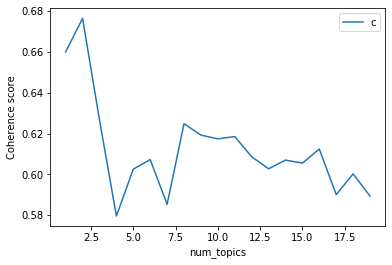

In [26]:
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=processed_docs, limit=20)

In [27]:
pyLDAvis.gensim.prepare(lmlist[2], corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.155684 -0.030391       1        1  37.564991
1     -0.114942 -0.080454       2        1  31.886375
2     -0.040742  0.110845       3        1  30.548637, topic_info=     Category          Freq             Term         Total  loglift  logprob
124   Default  15639.000000           fedora  15639.000000  30.0000  30.0000
129   Default   4731.000000            cento   4731.000000  29.0000  29.0000
130   Default   2324.000000             cesa   2324.000000  28.0000  28.0000
181   Default   3648.000000           debian   3648.000000  27.0000  27.0000
180   Default   4325.000000         advisori   4325.000000  26.0000  26.0000
226   Default   2744.000000             suse   2744.000000  25.0000  25.0000
1875  Default   2605.000000          opensus   2605.000000  24.0000  24.0000
81    Default   1637.000000            oracl   1637.000000  23.0000  23.0000
122   Default   3191.000000           ubuntu   3191.000000  22.0000  22.0000
5216  Default    879.000000             elsa    879.000000  21.0000  21.0000
155   Default   4363.000000           window   4363.000000  20.0000  20.0000
0     Default   1470.000000        microsoft   1470.000000  19.0000  19.0000
205   Default   1020.000000           kernel   1020.000000  18.0000  18.0000
127   Default    587.000000        check_ala    587.000000  17.0000  17.0000
174   Default    590.000000     googl_chrome    590.000000  16.0000  16.0000
126   Default    590.000000     amazon_local    590.000000  15.0000  15.0000
193   Default    345.000000            mdvsa    345.000000  14.0000  14.0000
154   Default    683.000000  mozilla_firefox    683.000000  13.0000  13.0000
192   Default    405.000000         mandriva    405.000000  12.0000  12.0000
5211  Default    296.000000     mageia_local    296.000000  11.0000  11.0000
5212  Default    325.000000            mfsa_    325.000000  10.0000  10.0000
5210  Default    295.000000      check_mgasa    295.000000   9.0000   9.0000
521   Default    589.000000  microsoft_offic    589.000000   8.0000   8.0000
4633  Default    248.000000      servic_pack    248.000000   7.0000   7.0000
219   Default    458.000000             file    458.000000   6.0000   6.0000
211   Default    314.000000            samba    314.000000   5.0000   5.0000
474   Default    355.000000         chromium    355.000000   4.0000   4.0000
15    Default   1184.000000       cross_site   1184.000000   3.0000   3.0000
147   Default   1182.000000       remot_code   1182.000000   2.0000   2.0000
157   Default    326.000000     java_openjdk    326.000000   1.0000   1.0000
...       ...           ...              ...           ...      ...      ...
432    Topic3     95.138039  activex_control    123.158722   0.9277  -6.1487
2042   Topic3     71.547562    featur_bypass     89.625183   0.9606  -6.4337
310    Topic3     84.423988           august    108.925125   0.9310  -6.2682
521    Topic3    368.829926  microsoft_offic    589.096069   0.7176  -4.7937
240    Topic3    293.429657          paramet    461.467102   0.7331  -5.0224
449    Topic3    172.007629      file_includ    253.034210   0.7999  -5.5565
147    Topic3    627.783142       remot_code   1182.357422   0.5528  -4.2618
44     Topic3    292.283356             bind    477.934265   0.6941  -5.0263
122    Topic3   1404.115356           ubuntu   3191.495605   0.3648  -3.4569
236    Topic3    309.363068        wordpress    516.747742   0.6728  -4.9695
145    Topic3    674.297485           execut   1382.841309   0.4676  -4.1903
411    Topic3    317.821777             java    580.220825   0.5839  -4.9425
52     Topic3    146.378860         overflow    217.602661   0.7894  -5.7178
144    Topic3    352.334686      thunderbird    661.560791   0.5558  -4.8394
168    Topic3    415.585663            remot    896.408630   0.4171  -4.6743
6017   Topic3    180.026825         slackwar    293.623932   0.6967 

In [28]:
def ret_top_model(texts):
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    lm_list = []
    while top_topics[0][1] < 0.74:
        print(top_topics[0][1])
        #lm = LdaModel(corpus=corpus, id2word=dictionary)
        lm = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary)
        lm_list.append(lm)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics



In [29]:
lm, top_topics = ret_top_model(processed_docs)

0


In [30]:
print(top_topics[:5])

[(2, 0.7587541458940849), (12, 0.7587541458940849), (15, 0.7587541458940849), (22, 0.7587541458940849), (25, 0.7587541458940849)]


In [31]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])

[[('download_fil', 0.0001210507),
  ('dcde', 0.0001210507),
  ('wireshark_profinet', 0.0001210507),
  ('datapow', 0.0001210507),
  ('product_januari', 0.0001210507),
  ('udan', 0.0001210507),
  ('iologik', 0.0001210507),
  ('unadf', 0.0001210507),
  ('kcoreaddon', 0.0001210507),
  ('videogalleri', 0.0001210507)],
 [('download_fil', 0.0001210507),
  ('dcde', 0.0001210507),
  ('wireshark_profinet', 0.0001210507),
  ('datapow', 0.0001210507),
  ('product_januari', 0.0001210507),
  ('udan', 0.0001210507),
  ('iologik', 0.0001210507),
  ('unadf', 0.0001210507),
  ('kcoreaddon', 0.0001210507),
  ('videogalleri', 0.0001210507)],
 [('download_fil', 0.0001210507),
  ('dcde', 0.0001210507),
  ('wireshark_profinet', 0.0001210507),
  ('datapow', 0.0001210507),
  ('product_januari', 0.0001210507),
  ('udan', 0.0001210507),
  ('iologik', 0.0001210507),
  ('unadf', 0.0001210507),
  ('kcoreaddon', 0.0001210507),
  ('videogalleri', 0.0001210507)],
 [('download_fil', 0.0001210507),
  ('dcde', 0.00012105

In [32]:
lda_lsi_topics = [[word for word, prob in lm.show_topic(topicid)] for topicid, c_v in top_topics]

In [33]:
lsitopics = lsimodel.show_topics(formatted=False)
hdptopics = hdpmodel.show_topics(formatted=False)
lmtopics = lmlist[5].show_topics(formatted=False)
ldatopics = ldamodel.show_topics(formatted=False)
lda_lsi_topics = [[word for word, prob in lm.show_topic(topicid)] for topicid, c_v in top_topics]

In [34]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]
lmtopics = [[word for word, prob in topic] for topicid, topic in lmtopics]

In [35]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=processed_docs, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=processed_docs, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=processed_docs, dictionary=dictionary, window_size=10).get_coherence()

lm_coherence = CoherenceModel(topics=lmtopics, texts=processed_docs, dictionary=dictionary, window_size=10).get_coherence()

lda_lsi_coherence = CoherenceModel(topics=lda_lsi_topics[:10], texts=processed_docs, dictionary=dictionary, window_size=10).get_coherence()

In [36]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')



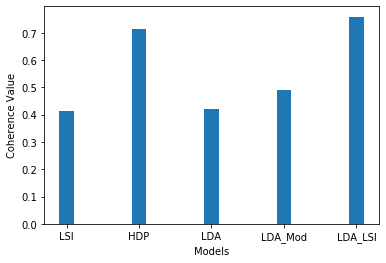

In [37]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, lm_coherence, lda_lsi_coherence],
                   ['LSI', 'HDP', 'LDA', 'LDA_Mod', 'LDA_LSI'])

In [38]:
#hdpmodel.save('openvas_hatstall_hdp.model')

Testing model with unseen documents

In [39]:
unseen_document = 'Mozilla Firefox SVG Navigation Privilege Escalation Vulnerability Mar15 (Windows)'
print(preprocess(unseen_document))
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(ldamodel[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, ldamodel.print_topic(index,5)))

['mozilla', 'firefox', 'navig', 'privileg', 'escal', 'window']
Score: 0.34749898314476013	 Topic: 0.298*"opensus" + 0.200*"suse" + 0.142*"cento" + 0.071*"cesa" + 0.021*"thunderbird"
Score: 0.34152090549468994	 Topic: 0.209*"window" + 0.052*"mozilla_firefox" + 0.041*"mfsa_" + 0.036*"mingw" + 0.029*"buffer_overflow"
Score: 0.1953176110982895	 Topic: 0.059*"openssl" + 0.044*"privileg_escal" + 0.043*"file" + 0.035*"core" + 0.034*"webkit"
Score: 0.01653263345360756	 Topic: 0.289*"ubuntu" + 0.068*"redhat" + 0.068*"rhsa" + 0.047*"java_openjdk" + 0.043*"qemu"
Score: 0.016523271799087524	 Topic: 0.729*"fedora" + 0.028*"kernel" + 0.009*"drupal" + 0.008*"graphicsmagick" + 0.007*"firefox"
Score: 0.016522498801350594	 Topic: 0.124*"microsoft" + 0.123*"window" + 0.069*"denial_servic" + 0.049*"server" + 0.041*"wireshark"
Score: 0.01652166061103344	 Topic: 0.147*"apsb" + 0.079*"player" + 0.074*"adob_flash" + 0.058*"window" + 0.053*"googl_chrome"
Score: 0.016520917415618896	 Topic: 0.078*"execut" + 0.0

In [40]:
print(lm[bow_vector])
for index, score in sorted(lm[bow_vector], key=lambda tup: -1*tup[1]):
    print(index,score)
    lm

[(14, 0.5025465), (69, 0.25242487)]
14 0.5025466
69 0.2524248


In [41]:
result_file = 'ResultsFromScan.csv'
openvas_result_df = pd.read_csv(result_file)
openvas_result_df = openvas_result_df.query('cvss != 0.0')

In [42]:
openvas_result_df['topic_label'] = openvas_result_df.signature.apply(preprocess)
openvas_result_df['topic_label'] = openvas_result_df.topic_label.apply(dictionary.doc2bow)


In [43]:
sorted(ldamodel[bow_vector][0])[1]

0.34152085

In [44]:
openvas_result_df['topic_label'] = openvas_result_df.topic_label.apply(lambda x: sorted(ldamodel[x][0])[1])

In [45]:
openvas_result_df

country                                              cve{}  cvss     oid  \
0       MEX  CVE-2016-2827\nCVE-2016-5270\nCVE-2016-5271\nC...   7.5  809324   
1       MEX  CVE-2016-5556\nCVE-2016-5568\nCVE-2016-5582\nC...   9.3  809393   
2       MEX                                      CVE-2013-6167   6.8  804501   
3       MEX  CVE-2015-6040\nCVE-2015-6122\nCVE-2015-6124\nC...   9.3  806177   
4       MEX  CVE-2017-0267\nCVE-2017-0268\nCVE-2017-0269\nC...   9.3  811117   
5       MEX                       CVE-2015-0081\nCVE-2015-0096   9.3  805053   
6       MEX                                      CVE-2017-7269  10.0  140228   
7       MEX                                      CVE-2014-4971   7.2  804492   
8       MEX        CVE-2014-0318\nCVE-2014-1819\nCVE-2014-4064   7.2  804807   
9       MEX                                      CVE-2015-0011   4.7  805038   
10      MEX  CVE-2016-7268\nCVE-2016-7276\nCVE-2016-7298\nC...   9.3  809750   
11      MEX                       CVE-2016-0122\nCVE-2016-0136   9.3  807319   
12      MEX  CVE-2016-3360\nCVE-2016-3358\nCVE-2016-3359\nC...   9.3  807365   
13      MEX                                      CVE-2008-5416   9.0  800082   
14      MEX  CVE-2016-1006\nCVE-2016-1011\nCVE-2016-1012\nC...  10.0  807653   
15      MEX  CVE-2014-0235\nCVE-2014-1751\nCVE-2014-1752\nC...   9.3  804535   
16      MEX                                      CVE-2016-0145   9.3  807800   
17      MEX                                      CVE-2017-8461   6.9  811207   
18      MEX                       CVE-2015-6038\nCVE-2015-6092   9.3  806162   
20      MEX  CVE-2012-1529\nCVE-2012-2546\nCVE-2012-2548\nC...   9.3  803028   
21      MEX                                      CVE-2015-2374   3.3  805075   
22      MEX  CVE-2017-2982\nCVE-2017-2984\nCVE-2017-2985\nC...  10.0  810551   
23      MEX  CVE-2016-1096\nCVE-2016-1097\nCVE-2016-1098\nC...  10.0  807698   
24      MEX  CVE-2014-0538\nCVE-2014-0540\nCVE-2014-0541\nC...  10.0  804742   
25      MEX  CVE-2015-5124\nCVE-2015-5125\nCVE-2015-5127\nC...  10.0  805954   
26      MEX                                      CVE-2015-1637   4.3  805490   
27      MEX  CVE-2016-4172\nCVE-2016-4173\nCVE-2016-4174\nC...  10.0  808578   
28      MEX  CVE-2016-5250\nCVE-2016-5268\nCVE-2016-5266\nC...   7.5  808640   
29      MEX                       CVE-2009-2536\nCVE-2009-1692   7.1  800669   
30      MEX  CVE-2016-3458\nCVE-2016-3485\nCVE-2016-3500\nC...   5.0  808621   
..      ...                                                ...   ...     ...   
469     MEX                       CVE-2013-0006\nCVE-2013-0007   9.3  903101   
470     MEX                       CVE-2011-1868\nCVE-2011-1869  10.0  900288   
471     MEX                       CVE-2011-1269\nCVE-2011-1270   9.3  902430   
472     MEX                                      CVE-2009-1335   4.3  900337   
473     MEX                                      CVE-2014-0271   9.3  903229   
474     MEX        CVE-2014-0498\nCVE-2014-0499\nCVE-2014-0502  10.0  903338   
475     MEX                                      CVE-2011-0034   9.3  902363   
476     MEX                                      CVE-2013-5056   9.3  903505   
480     MEX                                                NaN  10.0  103674   
485     MEX                                      CVE-2011-1253   9.3  902581   
486     MEX  CVE-2013-3184\nCVE-2013-3186\nCVE-2013-3187\nC...   9.3  903315   
487     MEX                                      CVE-2013-1301   4.3  902967   
488     MEX                                      CVE-2013-1335   9.3  902968   
489     MEX  CVE-2013-0001\nCVE-2013-0002\nCVE-2013-0003\nC...   9.3  902939   
490     MEX  CVE-2013-1297\nCVE-2013-0811\nCVE-2013-1306\nC...   9.3  903307   
492     MEX                                      CVE-2011-1991   9.3  901205   
494     MEX                                                NaN   5.0   10736   
500     MEX  CVE-2011-1272\nCVE-2011-1273\nCVE-2011-1274\nC...   9.3  902378   
501 